Adam training completed.
RMSprop training completed.


C:\Users\amanb\AppData\Local\Temp\ipykernel_48832\47495532.py:65: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1519.)
  m.mul_(beta1).add_(1 - beta1, grad)


Madam training completed.


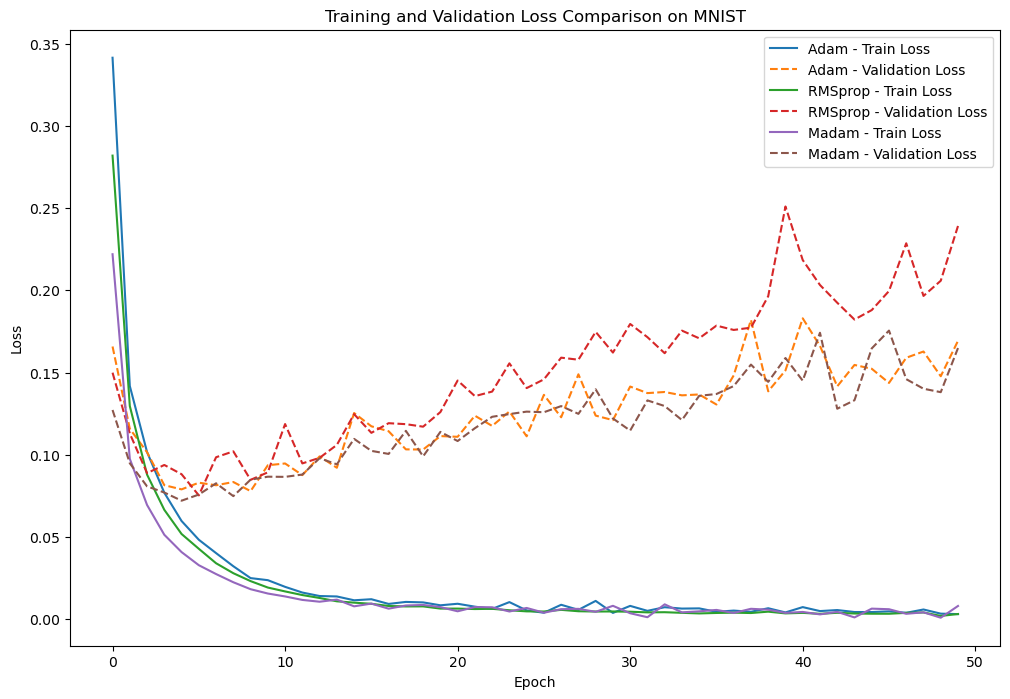

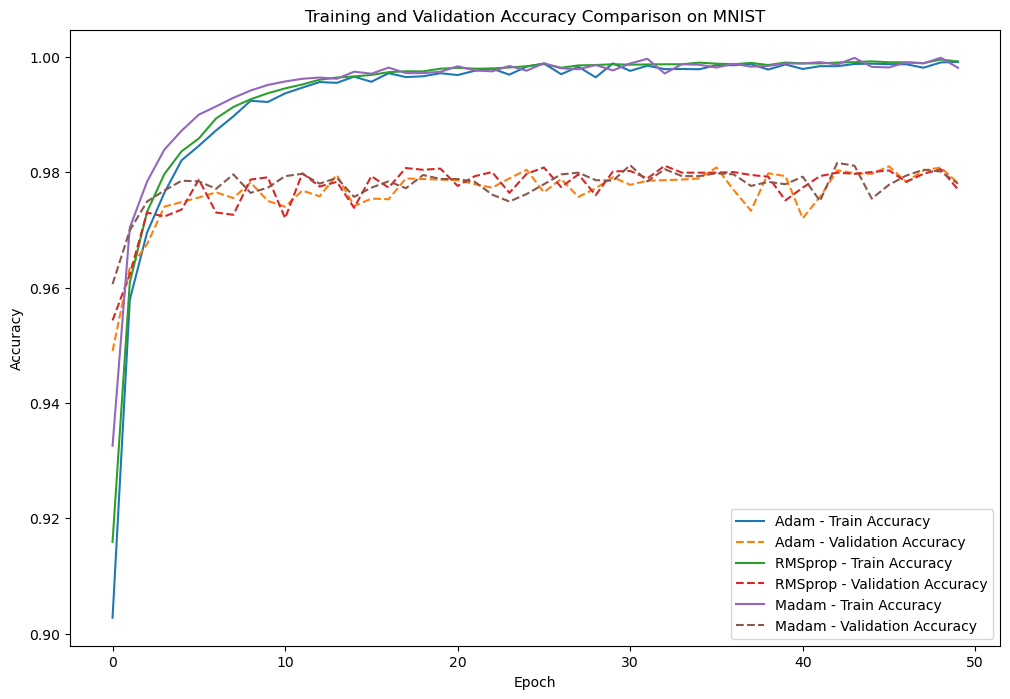

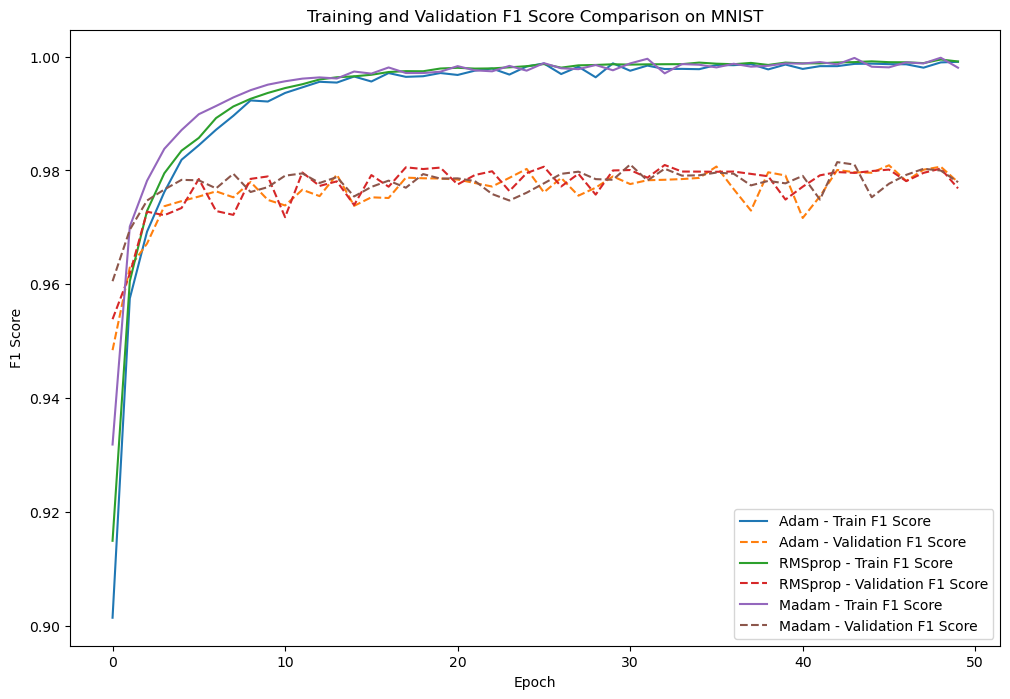

Adam - Min Training Loss: 0.0029, Min Validation Loss: 0.0778
Adam - Max Training Accuracy: 0.9991, Max Validation Accuracy: 0.9810
Adam - Max Training F1 Score: 0.9991, Max Validation F1 Score: 0.9809
RMSprop - Min Training Loss: 0.0018, Min Validation Loss: 0.0752
RMSprop - Max Training Accuracy: 0.9995, Max Validation Accuracy: 0.9811
RMSprop - Max Training F1 Score: 0.9995, Max Validation F1 Score: 0.9810
Madam - Min Training Loss: 0.0007, Min Validation Loss: 0.0720
Madam - Max Training Accuracy: 0.9998, Max Validation Accuracy: 0.9816
Madam - Max Training F1 Score: 0.9998, Max Validation F1 Score: 0.9815


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train, x_val = x_train / 255.0, x_val / 255.0  

x_train = torch.tensor(x_train.reshape(-1, 28*28), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_val = torch.tensor(x_val.reshape(-1, 28*28), dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class SimpleNet(nn.Module):
    def __init__(self, num_features):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class Madam(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        super(Madam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['m'] = torch.zeros_like(p.data)
                    state['k'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)

                m, k, v = state['m'], state['k'], state['v']
                beta1, beta2, eps, lr = group['beta1'], group['beta2'], group['eps'], group['lr']

                m.mul_(beta1).add_(1 - beta1, grad)
                k.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                v.mul_(beta1).addcdiv_(1 - beta1, grad / (torch.sqrt(k) + eps), v)

                look_ahead = p.data - lr * m / (torch.sqrt(k) + eps)
                p.data.add_(look_ahead - p.data)

        return loss

class adam_2(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        super(adam_2, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['v'] = torch.zeros_like(p.data)
                    state['k'] = torch.zeros_like(p.data)

                v, k = state['v'], state['k']
                beta1, beta2, eps, lr = group['beta1'], group['beta2'], group['eps'], group['lr']

                v.mul_(beta1).add_(grad, alpha=1 - beta1)
                k.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                lookahead_grad = grad - beta1 * v
                p.data.addcdiv_(lookahead_grad, torch.sqrt(k) + eps, value=-lr)

        return loss
    

def train_model_with_metrics(model, optimizer, train_loader, val_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        all_train_targets, all_train_preds = [], []
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_targets.extend(targets.cpu().numpy())
        
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracy = accuracy_score(all_train_targets, all_train_preds)
        train_f1 = f1_score(all_train_targets, all_train_preds, average='macro')
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)
        model.eval()
        running_val_loss = 0.0
        all_val_targets, all_val_preds = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_targets.extend(targets.cpu().numpy())
        
        val_losses.append(running_val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_val_targets, all_val_preds)
        val_f1 = f1_score(all_val_targets, all_val_preds, average='macro')
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

    return train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores


def create_optimizer(opt_name, model):
    if opt_name == "SGD":
        return optim.SGD(model.parameters(), lr=0.001)
    elif opt_name == "Adam":
        return optim.Adam(model.parameters(), lr=0.001)
    elif opt_name == "RMSprop":
        return optim.RMSprop(model.parameters(), lr=0.001)
    elif opt_name == "Madam":
        return Madam(model.parameters(), lr=0.001)
    
optimizers = [ "Adam", "RMSprop","Madam"]
num_epochs = 50
results = {}

for opt_name in optimizers:
    model = SimpleNet(num_features=28*28)  
    optimizer = create_optimizer(opt_name, model)
    train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores = train_model_with_metrics(
        model, optimizer, train_loader, val_loader, num_epochs=num_epochs)
    results[opt_name] = {
        'train_loss': train_losses, 
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies,
        'train_f1': train_f1_scores,
        'val_f1': val_f1_scores
    }
    print(f"{opt_name} training completed.")

plt.figure(figsize=(12, 8))
for opt_name, metrics in results.items():
    plt.plot(metrics['train_loss'], label=f"{opt_name} - Train Loss")
    plt.plot(metrics['val_loss'], label=f"{opt_name} - Validation Loss", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Comparison on MNIST")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for opt_name, metrics in results.items():
    plt.plot(metrics['train_accuracy'], label=f"{opt_name} - Train Accuracy")
    plt.plot(metrics['val_accuracy'], label=f"{opt_name} - Validation Accuracy", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Comparison on MNIST")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for opt_name, metrics in results.items():
    plt.plot(metrics['train_f1'], label=f"{opt_name} - Train F1 Score")
    plt.plot(metrics['val_f1'], label=f"{opt_name} - Validation F1 Score", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score Comparison on MNIST")
plt.legend()
plt.show()


for opt_name, metrics in results.items():
    min_train_loss = min(metrics['train_loss'])
    min_val_loss = min(metrics['val_loss'])
    max_train_accuracy = max(metrics['train_accuracy'])
    max_val_accuracy = max(metrics['val_accuracy'])
    max_train_f1 = max(metrics['train_f1'])
    max_val_f1 = max(metrics['val_f1'])
    print(f"{opt_name} - Min Training Loss: {min_train_loss:.4f}, Min Validation Loss: {min_val_loss:.4f}")
    print(f"{opt_name} - Max Training Accuracy: {max_train_accuracy:.4f}, Max Validation Accuracy: {max_val_accuracy:.4f}")
    print(f"{opt_name} - Max Training F1 Score: {max_train_f1:.4f}, Max Validation F1 Score: {max_val_f1:.4f}")
